In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Bước 1: Import Modules

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
import numpy as np
import requests
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.7.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Bước 2: Load bộ dữ liệu PhoNER

Thông tin các thực thể:

<b>PATIENT_ID</b>: Unique identifier of a COVID-19 patient in Vietnam. An PATIENT_ID annotation over “X” refers to as the Xth patient having COVID-19 in Vietnam.<br>
<b>PERSON_NAME</b>: Name of a patient or person who comes into contact with a patient.<br>
<b>AGE</b>: Age of a patient or person who comes into contact with a patient.
<b>GENDER</b>: Gender of a patient or person who comes into contact with a patient.<br>
<b>OCCUPATION</b>: Job of a patient or person who comes into contact with a patient.<br>
<b>LOCATION</b>: Locations/places that a patient was presented at.<br>
<b>ORGANIZATION</b>: Organizations related to a patient, e.g. company, government organization, and
the like, with structures and their own functions.<br>
<b>SYMPTOM&DISEASE</b>: Symptoms that a patient experiences, and diseases that a patient had prior to
COVID-19 or complications that usually appear in death reports.<br>
<b>TRANSPORTATION</b>: Means of transportation that a patient used. Here, we only tag the specific
identifier of vehicles, e.g. flight numbers and bus/car plates.<br>
<b>DATE</b>: Any date that appears in the sentence.<br>
Sau khi đọc tập dữ liệu, chúng ta quan sát thử 2 câu đầu tiên như thế nào.


In [ ]:
!git clone https://github.com/VinAIResearch/PhoNER_COVID19.git
%cd /content/PhoNER_COVID19

fatal: destination path 'PhoNER_COVID19' already exists and is not an empty directory.
/content/PhoNER_COVID19


In [ ]:
#Hàm này sẽ load dữ liệu đồng thời xử lý tạo danh sách các Word và Tag đã được loại bỏ giá trị trùng + Thêm phần đệm ENDPAD vào word
def read_conll_file(in_file_list):
  sentence,wt,word,tag = [],[],[],[]
  for in_file in in_file_list:
    with open(in_file) as f:
        for line in f.readlines():
            sp = line.strip().split('\t')
            word_tag = tuple(sp[0].split(" "))
            if len(word_tag) > 1:
              word.append(word_tag[0])
              tag.append(word_tag[1])
              wt.append(tuple(word_tag))
            else:
              sentence.append(wt)
              wt = []
  word = list(set(word))
  word.append("ENDPAD")
  tag = list(set(tag))
  return sentence,word,tag

In [ ]:
in_file_list = ["./data/word/train_word.conll","./data/word/dev_word.conll","./data/word/test_word.conll"]
sentence,words,tags = read_conll_file(in_file_list)
sentence[:50]

[[('Đồng_thời', 'O'),
  (',', 'O'),
  ('bệnh_viện', 'O'),
  ('tiếp_tục', 'O'),
  ('thực_hiện', 'O'),
  ('các', 'O'),
  ('biện_pháp', 'O'),
  ('phòng_chống', 'O'),
  ('dịch_bệnh', 'O'),
  ('COVID', 'O'),
  ('-', 'O'),
  ('19', 'O'),
  ('theo', 'O'),
  ('hướng_dẫn', 'O'),
  ('của', 'O'),
  ('Bộ', 'B-ORGANIZATION'),
  ('Y_tế', 'I-ORGANIZATION'),
  ('.', 'O')],
 [('"', 'O'),
  ('Số', 'O'),
  ('bệnh_viện', 'O'),
  ('có_thể', 'O'),
  ('tiếp_nhận', 'O'),
  ('bệnh_nhân', 'O'),
  ('bị', 'O'),
  ('sốt', 'B-SYMPTOM_AND_DISEASE'),
  ('cao', 'I-SYMPTOM_AND_DISEASE'),
  ('và', 'O'),
  ('khó', 'B-SYMPTOM_AND_DISEASE'),
  ('thở', 'I-SYMPTOM_AND_DISEASE'),
  ('đang', 'O'),
  ('giảm', 'O'),
  ('dần', 'O'),
  ('"', 'O'),
  (',', 'O'),
  ('thông_cáo', 'O'),
  ('có', 'O'),
  ('đoạn', 'O'),
  (',', 'O'),
  ('cảnh_báo', 'O'),
  ('những', 'O'),
  ('bệnh_nhân', 'O'),
  ('này', 'O'),
  ('thay', 'O'),
  ('vào', 'O'),
  ('đó', 'O'),
  ('được', 'O'),
  ('chuyển', 'O'),
  ('tới', 'O'),
  ('các', 'O'),
  ('phòng_khá

Thống kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu.
- Số lượng thẻ duy nhất trong tập dữ liệu.\

In [ ]:
print("Unique words in corpus:", len(words)-1)
print("Unique tags in corpus:", len(tags))

Unique words in corpus: 8101
Unique tags in corpus: 21


In [ ]:
num_words = len(words)
print(words)
print(num_words)

['tự', 'Thạnh_Mỹ_Lợi', '16/3', 'Nguyễn_Đức_Trung', 'kết_nối', 'N.T.P.N.', 'điện_tử', 'quên', 'Quá', 'Mầm_non', 'chuyển', 'Hướng_dẫn', 'Vietnam_News', '1016', '452', 'thời_kỳ', '6.000', 'ngược', 'Người_bệnh', 'Dị_ứng', '10/8', 'VN1547', 'Bạch_Mai_TTO', 'hắt_hơi', 'vé', 'từ', 'xét', 'Formica', 'virút', '1029', '931', 'Hoàng_Văn_Thụ', 'Cần', 'võ_sư', 'Phuket', 'ngon', '586', 'Đà_Năng', 'Vườn_Lài', '30E', 'xuyên', 'Xuyên', '581', '1032', 'H.T.Y.N.', 'Định_Hoà', 'tiến_triển', 'Trương_Hữu_Khanh', '726', 'Cáp_Thị_Yến', 'liệt_kê', 'Ninh_Binh', 'Phúc_Yên', '1.500', 'phó', 'Ý.', 'trao_đổi', '18', 'nói_chuyện', '1.592', 'mặt_đất', 'Hoà_An', 'phổ_biến', 'địa_chỉ', 'nếu', 'giấy', 'tím', 'tay_nghề', 'khoanh', '243', 'Tây', '12h3', 'công_bố', 'nấu_ăn', 'sơ_tán', 'thể', 'trú', 'địa_phương', '5/14', '957', 'N.T.S.', 'chân_thành', 'đại', 'vào', '794', 'Drew_Posey', 'Đức_Hạnh', 'tiêm', 'Dương', '590', 'Phổi_Quảng_Trị', 'bất_động', 'Ân_Thi', 'Bệnh_Viện', 'vượt', '14%', 'nỗ_lực', 'xịt', '224', 'ưu_ti

In [ ]:
num_tags = len(tags)
print(tags)
print(num_tags)

['B-LOCATION', 'B-TRANSPORTATION', 'B-PATIENT_ID', 'I-LOCATION', 'B-SYMPTOM_AND_DISEASE', 'O-ORGANIZATION', 'I-NAME', 'I-JOB', 'I-PATIENT_ID', 'B-GENDER', 'B-DATE', 'O', 'I-AGE', 'B-NAME', 'B-JOB', 'I-SYMPTOM_AND_DISEASE', 'I-DATE', 'B-AGE', 'I-TRANSPORTATION', 'I-ORGANIZATION', 'B-ORGANIZATION']
21


In [ ]:
print(len(words), len(tags))

8102 21


# Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
# word2idx
tag2idx 

{'B-AGE': 17,
 'B-DATE': 10,
 'B-GENDER': 9,
 'B-JOB': 14,
 'B-LOCATION': 0,
 'B-NAME': 13,
 'B-ORGANIZATION': 20,
 'B-PATIENT_ID': 2,
 'B-SYMPTOM_AND_DISEASE': 4,
 'B-TRANSPORTATION': 1,
 'I-AGE': 12,
 'I-DATE': 16,
 'I-JOB': 7,
 'I-LOCATION': 3,
 'I-NAME': 6,
 'I-ORGANIZATION': 19,
 'I-PATIENT_ID': 8,
 'I-SYMPTOM_AND_DISEASE': 15,
 'I-TRANSPORTATION': 18,
 'O': 11,
 'O-ORGANIZATION': 5}

Bước 5: Padding  đầu vào and cắt dữ liệu thành tập Train/Test\
Độ dài của câu trong tập dữ liệu khoảng 20 đến 22 dấu từ. Và trong trục X, có thể thấy giá trị an toàn là khoảng 60.

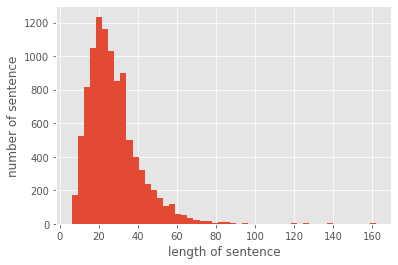

In [ ]:
plt.hist([len(s) for s in sentence], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 60
def ToSequence(sentences,max_len,num_words,num_tags):
  X = [[word2idx[w[0]] for w in s] for s in sentences]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
  y = [[tag2idx[w[1]] for w in s] for s in sentences]
  y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
  return X,y
X,y = ToSequence(sentence,max_len,num_words,num_tags)

In [ ]:
print(X[0])
print(y[0])

[6074 2277 1529 1438  366  143 2377 5846 2427 2976 6705 6659 3873 5592
 6176 7619 3341 1789 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101]
[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 20 19 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11]


- test_size = 0.2 có nghĩa là 95% dữ liệu chia cho tập huấn luyện và 5% còn lại cho tập kiểm tra.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

# Bước 6: Xây dựng Mô hình


In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense,GRU,Conv1D
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam

## Bi-LSTM

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.compile(optimizer=Adam(lr = 2e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding (Embedding)       (None, 60, 60)            486120    
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 60)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          128800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 60, 21)           4221      
 ibuted)                                                         
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Bước7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [ ]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()
history = model.fit(
    x=X,
    y=y,
    #validation_data=(x_,y_valid),
    validation_split= 0.05,
    batch_size= 128, 
    epochs=10,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))

Epoch 1/10
75/75 [==============================] - 62s 753ms/step - loss: 1.7733 - accuracy: 0.8495 - val_loss: 0.5358 - val_accuracy: 0.9058
Epoch 2/10
75/75 [==============================] - 56s 741ms/step - loss: 0.5404 - accuracy: 0.8944 - val_loss: 0.4650 - val_accuracy: 0.9058
Epoch 3/10
75/75 [==============================] - 56s 748ms/step - loss: 0.5071 - accuracy: 0.8944 - val_loss: 0.4518 - val_accuracy: 0.9058
Epoch 4/10
75/75 [==============================] - 56s 747ms/step - loss: 0.4941 - accuracy: 0.8944 - val_loss: 0.4412 - val_accuracy: 0.9058
Epoch 5/10
75/75 [==============================] - 55s 738ms/step - loss: 0.4791 - accuracy: 0.8944 - val_loss: 0.4251 - val_accuracy: 0.9058
Epoch 6/10
75/75 [==============================] - 55s 735ms/step - loss: 0.4570 - accuracy: 0.8944 - val_loss: 0.3991 - val_accuracy: 0.9059
Epoch 7/10
75/75 [==============================] - 55s 739ms/step - loss: 0.4251 - accuracy: 0.8944 - val_loss: 0.3648 - val_accuracy: 0.9060

In [ ]:
model.save_weights("/content/drive/MyDrive/NCKH-WEIGHT&CFG/NLPforDS/BTTH3/Cau2_LSTM_weight.h5")
model.save("/content/drive/MyDrive/NCKH-WEIGHT&CFG/NLPforDS/BTTH3/Cau2_LSTM.h5")

# Bước8: Đánh giá mô hình NER


In [ ]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 1s 59ms/step - loss: 0.2925 - accuracy: 0.9202


[0.2924613654613495, 0.9202191233634949]

- Dự đoán

In [ ]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
Trong          O	O
số             O	O
15             O	O
bệnh_nhân      O	O
đang           O	O
còn            O	O
ở              O	O
lại            O	O
các            O	O
bệnh_viện      O	O
,              O	O
14/15          O	O
đều            O	O
ổn_định        O	O
và             O	O
có             O	O
tiến_triển     O	O
tốt            O	O
,              O	O
bệnh_nhân      O	O
91             B-PATIENT_ID	O
phi_công       B-JOB	O
người          O	O
Anh            O	O
là             O	O
bệnh_nhân      O	O
duy_nhất       O	O
còn            O	O
ở              O	O
tình_trạng     O	O
nặng           O	O
,              O	O
đang           O	O
thở            O	O
máy            O	O
,              O	O
tuy_nhiên      O	O
so             O	O
với            O	O
nửa            O	O
tháng          O	O
trước          O	O
tiến_triển     O	O
đã             O	O
rất            O	O
tốt            O	O
và             O	O
được           O	O
cho           

# F1-score

In [ ]:
from sklearn.metrics import classification_report
def Report(model,x_test,y_test):
  y_predict = model.predict(x_test)
  y_predict = np.argmax(y_predict, axis=-1)

  y_predict = y_predict.reshape(1,-1)[0]
  y_true = y_test.reshape(1,-1)[0]

  entity_predict = [tags[i] for i in y_predict]
  entity_true = [tags[i] for i in y_true]

  report = classification_report(entity_true,entity_predict)
  return report
report = Report(model,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
report = Report(model,x_test,y_test)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                B-AGE       0.00      0.00      0.00        77
               B-DATE       0.00      0.00      0.00       272
             B-GENDER       0.00      0.00      0.00        65
                B-JOB       0.00      0.00      0.00        37
           B-LOCATION       0.60      0.40      0.48       615
               B-NAME       0.00      0.00      0.00        39
       B-ORGANIZATION       0.00      0.00      0.00       107
         B-PATIENT_ID       0.00      0.00      0.00       333
B-SYMPTOM_AND_DISEASE       0.00      0.00      0.00       155
     B-TRANSPORTATION       0.00      0.00      0.00        24
                I-AGE       0.00      0.00      0.00         1
               I-DATE       0.00      0.00      0.00       244
                I-JOB       0.00      0.00      0.00        20
           I-LOCATION       0.47      0.71      0.57       661
               I-NAME       0.00      0.00      0.00  